In [3]:
%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import cmocean.cm as cmo
#import holoviews as hv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [22]:
def colorea (plot, axis, units):
    """
    Creates a colorbar for the given axis, with appropriate units & font sizes
    
    Parameters:
    -----------
        plot: plot in which to create the colorbar
        axis: axis in which to create the colorbar
        units: string with units of the colorbar
    """
    
    cb = plt.colorbar(plot, ax=axis)
    cb.ax.tick_params(labelsize=20)
    cb.set_label(units, fontsize=20)

In [23]:
dsm = xr.open_mfdataset('output030/ocean/ocean_month.nc', combine='by_coords')

In [24]:
dso = xr.open_mfdataset('output030/ocean/ocean.nc', combine='by_coords')

In [25]:
dsm_c = xr.open_mfdataset('/g/data3/hh5/tmp/cosima/access-om2/1deg_jra55_ryf9091_spinup1_B1/output030/ocean/ocean_month.nc', combine='by_coords')

In [62]:
dso_c = xr.open_mfdataset('/g/data3/hh5/tmp/cosima/access-om2/1deg_jra55_ryf9091_spinup1_B1/output030/ocean/ocean.nc', combine='by_coords')

In [258]:
!ncdump -h 'output000/ocean/ocean_month.nc'

netcdf ocean_month {
dimensions:
	xt_ocean = 360 ;
	yt_ocean = 300 ;
	time = UNLIMITED ; // (60 currently)
	nv = 2 ;
	xu_ocean = 360 ;
	yu_ocean = 300 ;
variables:
	double xt_ocean(xt_ocean) ;
		xt_ocean:long_name = "tcell longitude" ;
		xt_ocean:units = "degrees_E" ;
		xt_ocean:cartesian_axis = "X" ;
	double yt_ocean(yt_ocean) ;
		yt_ocean:long_name = "tcell latitude" ;
		yt_ocean:units = "degrees_N" ;
		yt_ocean:cartesian_axis = "Y" ;
	double time(time) ;
		time:long_name = "time" ;
		time:units = "days since 1900-01-01 00:00:00" ;
		time:cartesian_axis = "T" ;
		time:calendar_type = "NOLEAP" ;
		time:calendar = "NOLEAP" ;
		time:bounds = "time_bounds" ;
	double nv(nv) ;
		nv:long_name = "vertex number" ;
		nv:units = "none" ;
		nv:cartesian_axis = "N" ;
	double xu_ocean(xu_ocean) ;
		xu_ocean:long_name = "ucell longitude" ;
		xu_ocean:units = "degrees_E" ;
		xu_ocean:cartesian_axis = "X" ;
	double yu_ocean(yu_ocean) ;
		yu_ocean:long_name = "ucell latitude" ;
		yu_ocean:units = "deg

In [266]:
dsm.data_vars

Data variables:
    sea_level              (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(60, 300, 360), meta=np.ndarray>
    eta_t                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(60, 300, 360), meta=np.ndarray>
    sea_levelsq            (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(60, 300, 360), meta=np.ndarray>
    mld                    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(60, 300, 360), meta=np.ndarray>
    pme_river              (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(60, 300, 360), meta=np.ndarray>
    river                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(60, 300, 360), meta=np.ndarray>
    runoff                 (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(60, 300, 360), meta=np.ndarray>
    ice_calving            (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(60, 300, 360), meta=np.ndarray>
    evap                   (time, yt_ocean, xt_ocean) fl

# ANTARCTICA

In [9]:
import cartopy.feature as cfeature
import matplotlib.path as mpath

In [46]:
def antarctica(ax, max_lat, show_details):
    """
    Creates a stereographic, round plot of Antarctica
    
    Parameters:
    -----------
        ax: axis on which to plot Antarctica
        max_lat: negative integer with the maximum latitude to show (i.e. -°S)
        show_details: boolean indicating whether to plot the land, ocean & grids
    
    Returns:
    --------
        ax: axis with Antarctica plotted 
    """
    
    # Limit the map to max_lat degrees latitude and below
    ax.set_extent([-180, 180, -90, max_lat], ccrs.PlateCarree())

    if (show_details):
        ax.gridlines(color='SteelBlue', linestyle='--')
        ax.add_feature(cfeature.LAND)
        #ax.add_feature(cfeature.OCEAN)

    # Compute a circle in axes coordinates to use as the map's boundary
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)
    
    return ax

In [44]:
def stereo(data, mapa, limite, units, max_lat, show_details, yearly = True, calc = ""): 
    """
    Creates a series of 3 stereographic plots of Antarctica:
        control: plot to compare against (for example, the 1deg_jra_ryf9091_spinup_B1)
        experiment: plot with the run to study (for example, the LIG)
        differences: plot with the differences of the experiment against the run (i.e. experiment - control)
        
    Parameters:
    -----------
        data: string with the name of the data_var(iable) to be compared
        mapa: colormap to be used for plotting the data
        limite: negative float with the min (& max) value of the colorbar in the 'differences' plot,
                so that the colorbar is centered around 0
        units: string with the units of the colorbar
        max_lat: negative integer with the maximum latitude to show (i.e. -°S)
        show_details: boolean indicating whether to plot the land, ocean & grids
        yearly: boolean to specify whether the data is yearly data (and hence 4-dimensional, 
                with [time, depth, lat, lon]) or not (i.e. monthly data and hence 3-dimensional,
                with [time, lat, lon])
        calc: string with optional calculations to perform on the data 
             (e.g. to convert from °K to °C we would pass '- 273.15')
    """
        
    if (yearly):
        control = "dso_c." + data + "[:,1].sel(yt_ocean=slice(-90, max_lat)).mean('time')" + calc
        lig = "dso." + data + "[:,1].sel(yt_ocean=slice(-90, max_lat)).mean('time')" + calc
    else:
        control = "dsm_c." + data + ".sel(yt_ocean=slice(-90, max_lat)).mean('time')" + calc
        lig = "dsm." + data + ".sel(yt_ocean=slice(-90, max_lat)).mean('time')" + calc
        
    plt.figure(figsize=(30,45))
    
    ax1 = plt.subplot(3, 1, 1, projection=ccrs.SouthPolarStereo())
    ax1 = antarctica(ax1, max_lat, show_details)
    plot1 = ax1.contourf(dso_c.xt_ocean, dso_c.yt_ocean.sel(yt_ocean=slice(-90, max_lat)), 
                        eval(control), 15, cmap=mapa, transform=ccrs.PlateCarree(), zorder=2)#, alpha=0.5)
    colorea(plot1, ax1, units)
    plt.title('Control-9091', fontsize=40, pad=20)

    ax2 = plt.subplot(3, 1, 2, projection=ccrs.SouthPolarStereo())
    ax2 = antarctica(ax2, max_lat, show_details)
    plot2 = ax2.contourf(dso.xt_ocean, dso.yt_ocean.sel(yt_ocean=slice(-90, max_lat)), 
                        eval(lig), 15, cmap=mapa, transform=ccrs.PlateCarree(), zorder=2)#, alpha=0.5)
    colorea(plot2, ax2, units)
    plt.title('LIG', fontsize=40, pad=20)

    ax3 = plt.subplot(3, 1, 3, projection=ccrs.SouthPolarStereo())
    ax3 = antarctica(ax3, max_lat, show_details)
    plot3 = ax3.contourf(dso.xt_ocean, dso.yt_ocean.sel(yt_ocean=slice(-90, max_lat)), 
                        eval(lig) - eval(control), 
                        15, vmin = limite, vmax = abs(limite), 
                        cmap="RdYlBu_r", transform=ccrs.PlateCarree(), zorder=2)#, alpha=0.5)
    colorea(plot3, ax3, units)
    plt.title('Differences', fontsize=40, pad=20)

    plt.show()

# SEA-LEVEL

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


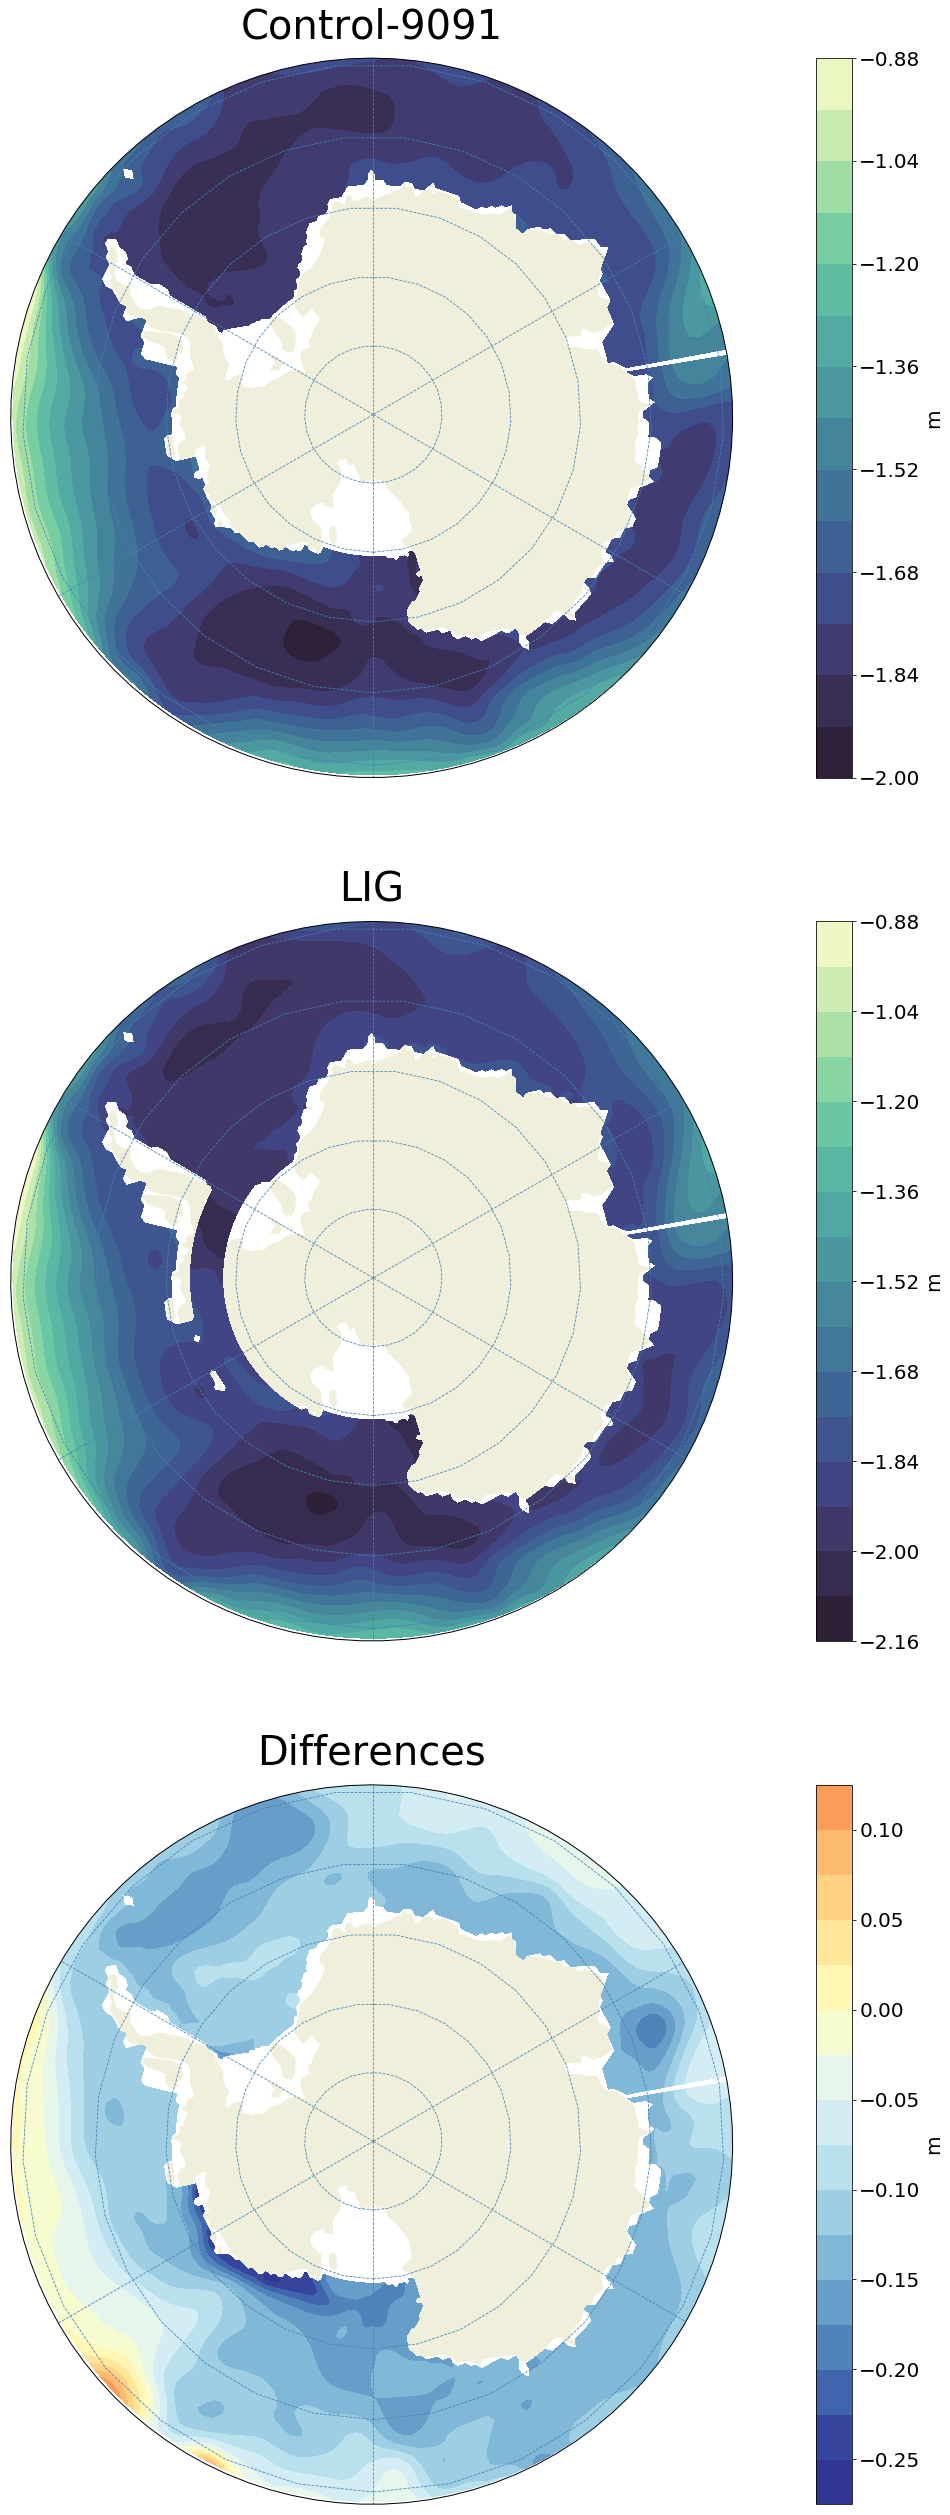

In [53]:
stereo("sea_level", cmo.deep_r, -0.25, "m", -59, True, False)

# MIXED-LAYER DEPTH

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


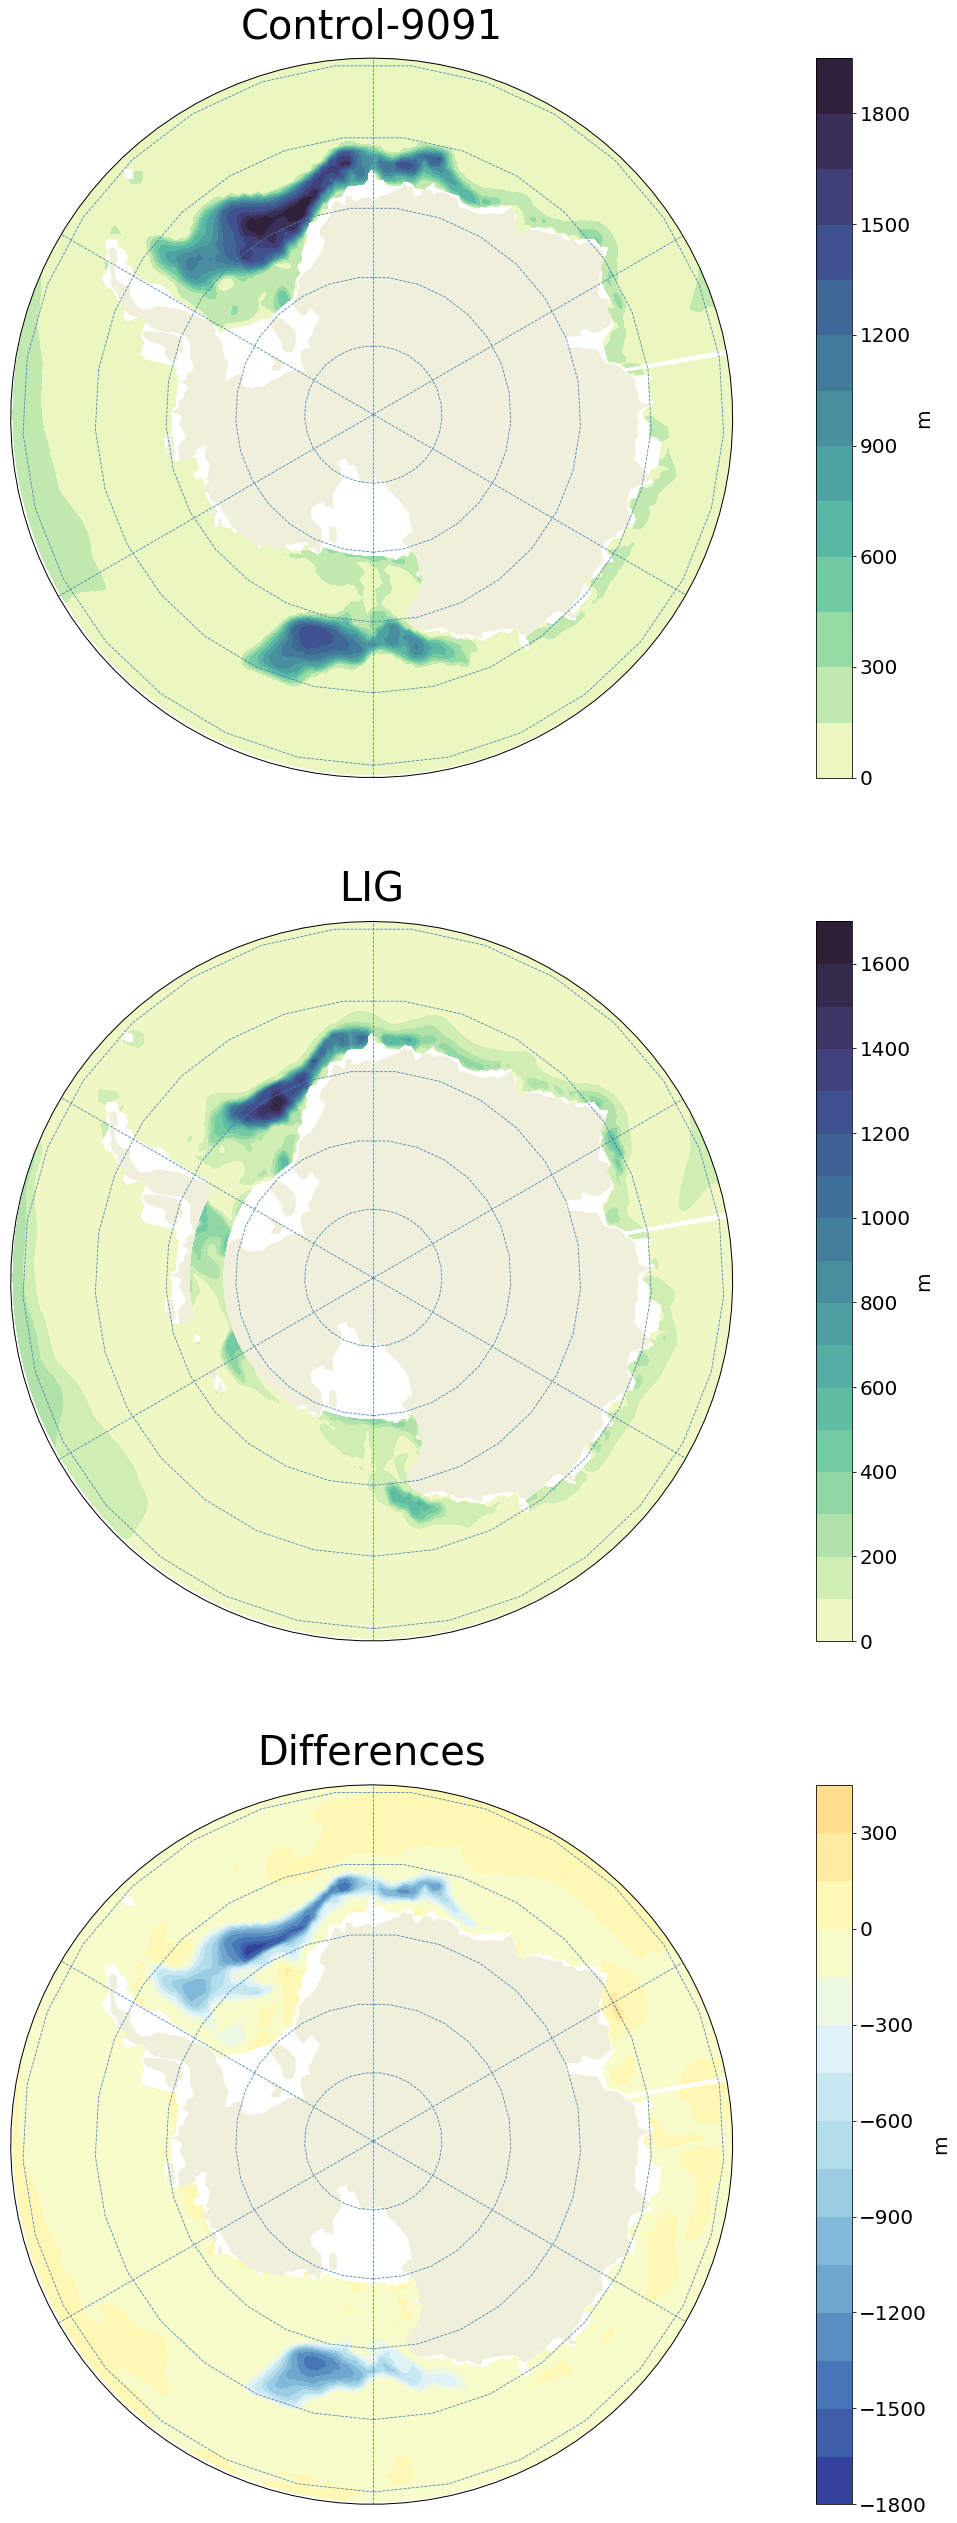

In [56]:
stereo("mld", cmo.deep, -1800, "m", -59, True, False)

# SURFACE CURRENTS

In [63]:
dso_c.u

<xarray.DataArray 'u' (time: 5, st_ocean: 50, yu_ocean: 300, xu_ocean: 360)>
dask.array<open_dataset-ffd3b9c176c1593b2081a7c61264481du, shape=(5, 50, 300, 360), dtype=float32, chunksize=(5, 50, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 1.152 3.649 6.565 ... 5.034e+03 5.254e+03
  * time      (time) object 2050-07-02 12:00:00 ... 2054-07-02 12:00:00
  * xu_ocean  (xu_ocean) float64 -279.0 -278.0 -277.0 -276.0 ... 78.0 79.0 80.0
  * yu_ocean  (yu_ocean) float64 -77.75 -77.51 -77.26 -77.01 ... 89.1 89.55 90.0
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_c
    standard_name:  sea_water_x_velocity

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


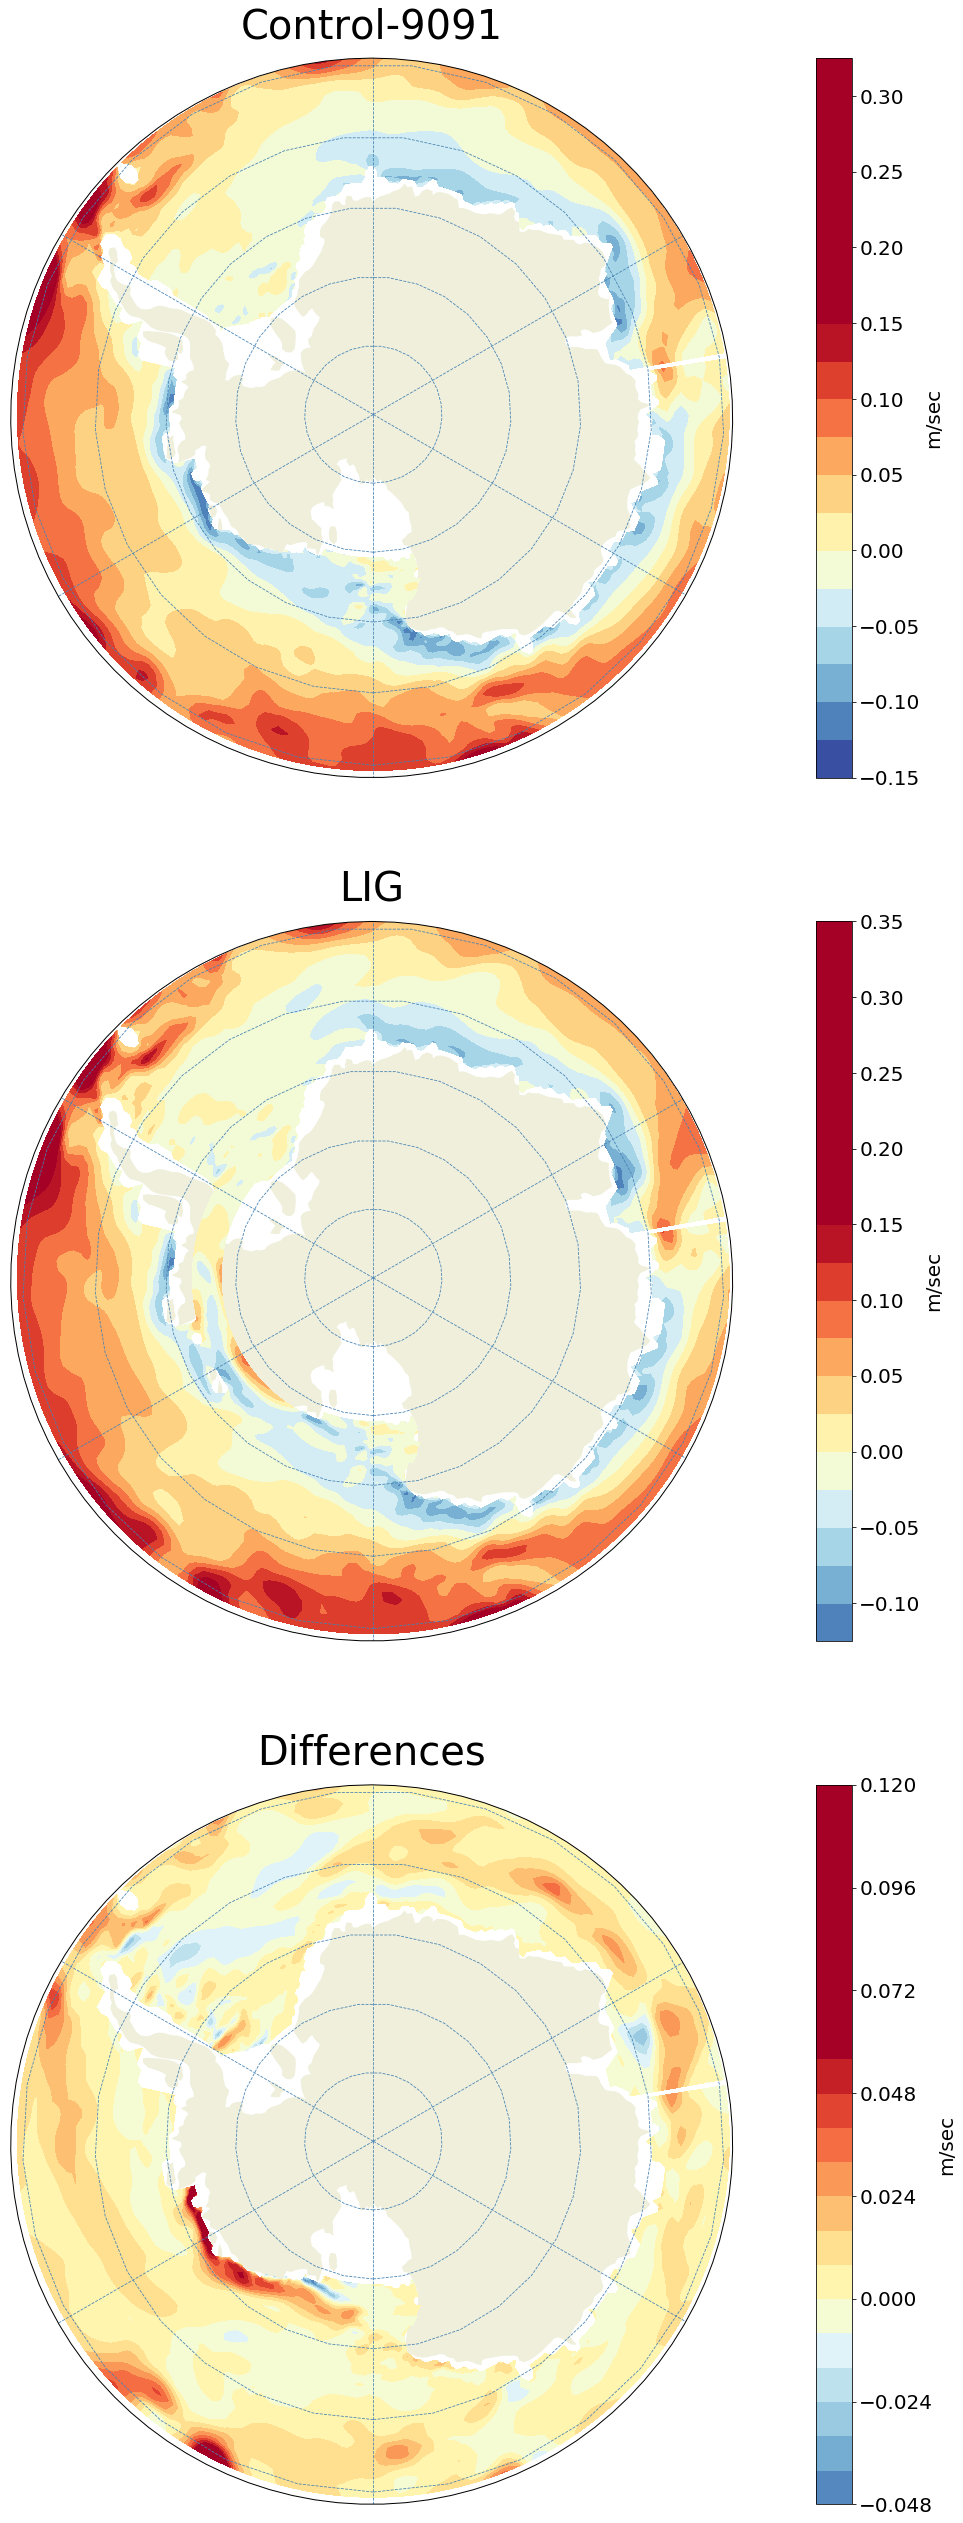

In [70]:
max_lat = -59
show_details = True
plt.figure(figsize=(30,45))

# Control
ax1 = plt.subplot(3, 1, 1, projection=ccrs.SouthPolarStereo())
ax1 = antarctica(ax1, max_lat, show_details)
plot1 = ax1.contourf(dso_c.xu_ocean, dso_c.yu_ocean.sel(yu_ocean=slice(-90, max_lat)), 
                    dso_c.u[:,1].sel(yu_ocean=slice(-90, max_lat)).mean('time'), 20, 
                    vmin=-0.15, vmax=0.15,
                    cmap="RdYlBu_r", transform=ccrs.PlateCarree(), zorder=2)#, alpha=0.5)
colorea(plot1, ax1, dso.u.units)
plt.title('Control-9091', fontsize=40, pad=20)


# Experiment
ax2 = plt.subplot(3, 1, 2, projection=ccrs.SouthPolarStereo())
ax2 = antarctica(ax2, max_lat, show_details)
plot2 = ax2.contourf(dso.xu_ocean, dso.yu_ocean.sel(yu_ocean=slice(-90, max_lat)), 
                    dso.u[:,1].sel(yu_ocean=slice(-90, max_lat)).mean('time'), 20, 
                    vmin=-0.15, vmax=0.15,
                    cmap="RdYlBu_r", transform=ccrs.PlateCarree(), zorder=2)#, alpha=0.5)
colorea(plot2, ax2, dso.u.units)
plt.title('LIG', fontsize=40, pad=20)


# Differences
ax3 = plt.subplot(3, 1, 3, projection=ccrs.SouthPolarStereo())
ax3 = antarctica(ax3, max_lat, show_details)
plot3 = ax3.contourf(dso.xu_ocean, dso.yu_ocean.sel(yu_ocean=slice(-90, max_lat)), 
                    dso.u[:,1].sel(yu_ocean=slice(-90, max_lat)).mean('time')
                    - dso_c.u[:,1].sel(yu_ocean=slice(-90, max_lat)).mean('time'), 20, 
                    vmin = -0.06, vmax = 0.06, 
                    cmap="RdYlBu_r", transform=ccrs.PlateCarree(), zorder=2)#, alpha=0.5)
colorea(plot3, ax3, dso.u.units)
plt.title('Differences', fontsize=40, pad=20)

plt.show()

# ACC

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1752: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value enc

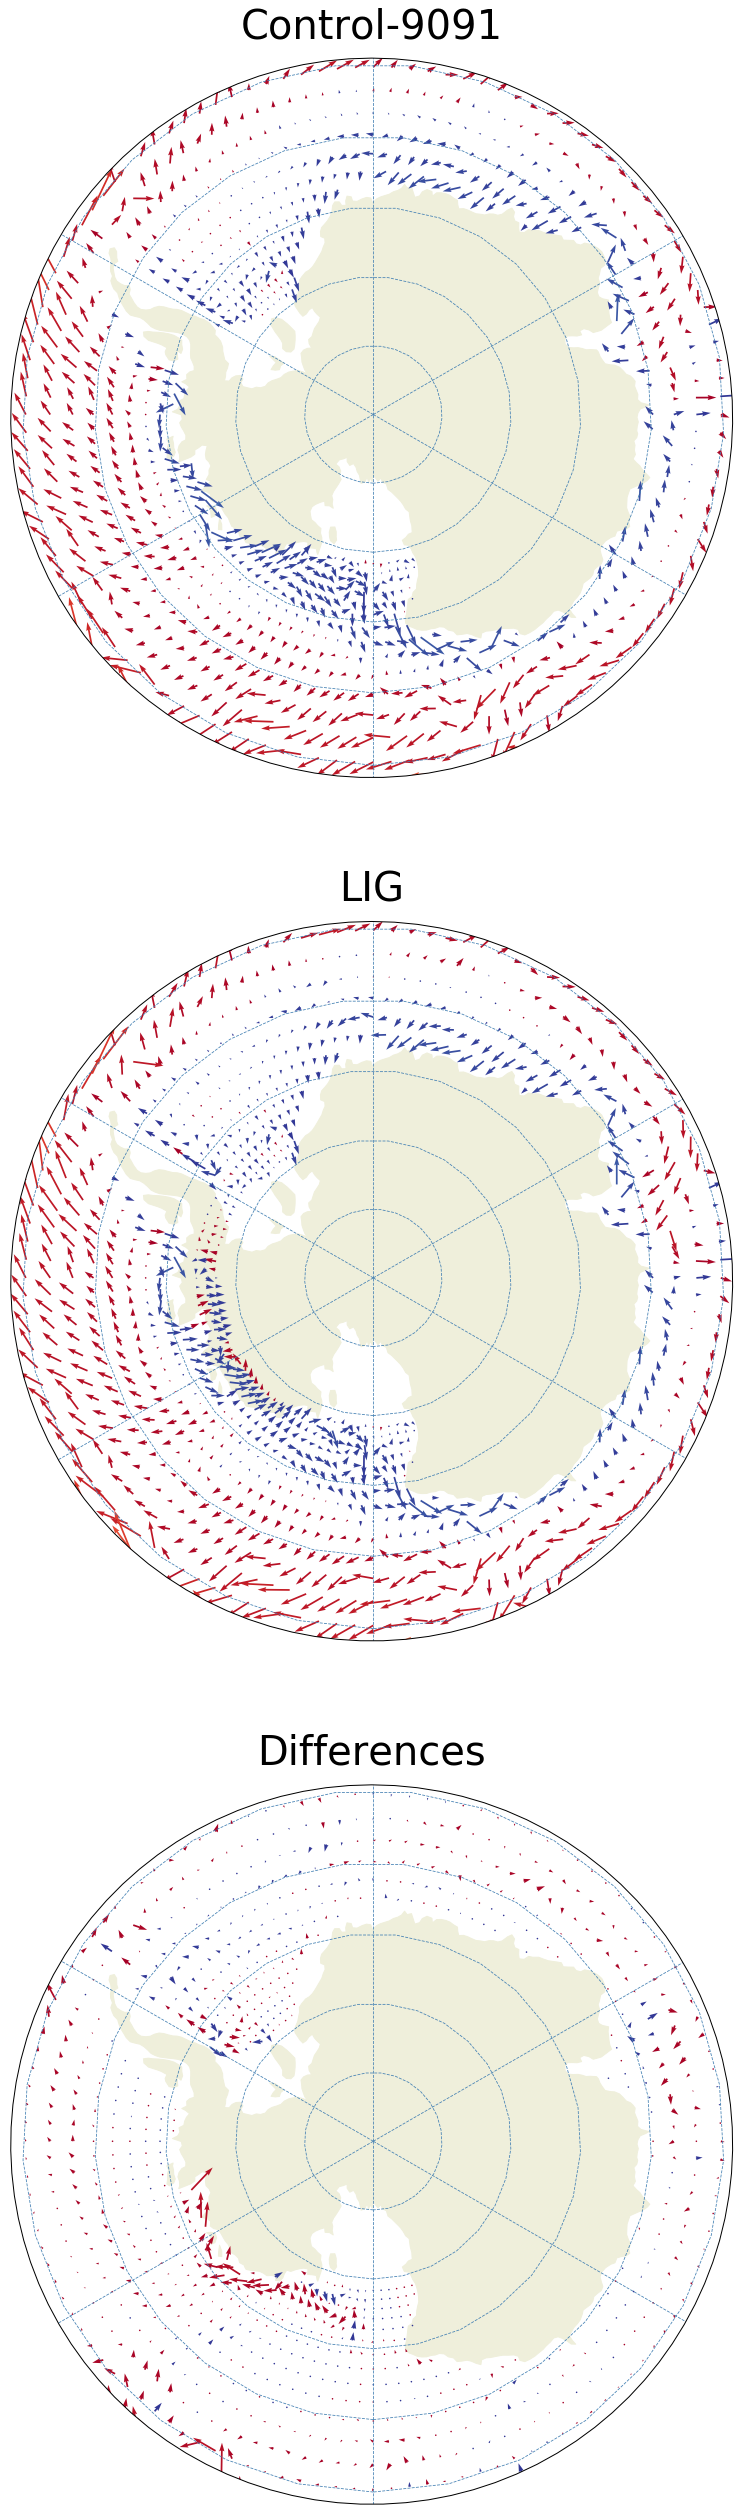

In [87]:
max_lat = -59
show_details = True
plt.figure(figsize=(30,45))

# ----- Control
# Select the top layer of the ocean
acc_u = dso_c.u[:,1].mean('time')
acc_v = dso_c.v[:,1].mean('time')

ax1 = plt.subplot(3, 1, 1, projection=ccrs.SouthPolarStereo())
ax1 = antarctica(ax1, max_lat, show_details)
# Base the color of the arrows on the u-velocity (bipolar)
magnitude = acc_u[::3, ::3] % 2
plot1 = ax1.quiver(acc_u.xu_ocean[::3].values, acc_u.yu_ocean[::3].values, acc_u[::3, ::3].values, acc_v[::3, ::3].values, 
          magnitude, transform=ccrs.PlateCarree(), scale=3, cmap='RdYlBu')
plt.title('Control-9091', fontsize=40, pad=20)


# ----- Experiment
acc_u = dso.u[:,1].mean('time')
acc_v = dso.v[:,1].mean('time')

ax2 = plt.subplot(3, 1, 2, projection=ccrs.SouthPolarStereo())
ax2 = antarctica(ax2, max_lat, show_details)
# Base the color of the arrows on the u-velocity (bipolar)
magnitude = acc_u[::3, ::3] % 2
plot2 = ax2.quiver(acc_u.xu_ocean[::3].values, acc_u.yu_ocean[::3].values, acc_u[::3, ::3].values, acc_v[::3, ::3].values, 
          magnitude, transform=ccrs.PlateCarree(), scale=3, cmap='RdYlBu')
plt.title('LIG', fontsize=40, pad=20)


# ----- Differences
acc_u = dso.u[:,1].mean('time') - dso_c.u[:,1].mean('time')
acc_v = dso.v[:,1].mean('time') - dso_c.v[:,1].mean('time')

ax3 = plt.subplot(3, 1, 3, projection=ccrs.SouthPolarStereo())
ax3 = antarctica(ax3, max_lat, show_details)
# Base the color of the arrows on the u-velocity (bipolar)
magnitude = acc_u[::3, ::3] % 2
plot3 = ax3.quiver(acc_u.xu_ocean[::3].values, acc_u.yu_ocean[::3].values, acc_u[::3, ::3].values, acc_v[::3, ::3].values, 
          magnitude, transform=ccrs.PlateCarree(), scale=2, cmap='RdYlBu')
plt.title('Differences', fontsize=40, pad=20)

plt.show()

# TEMPERATURE

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


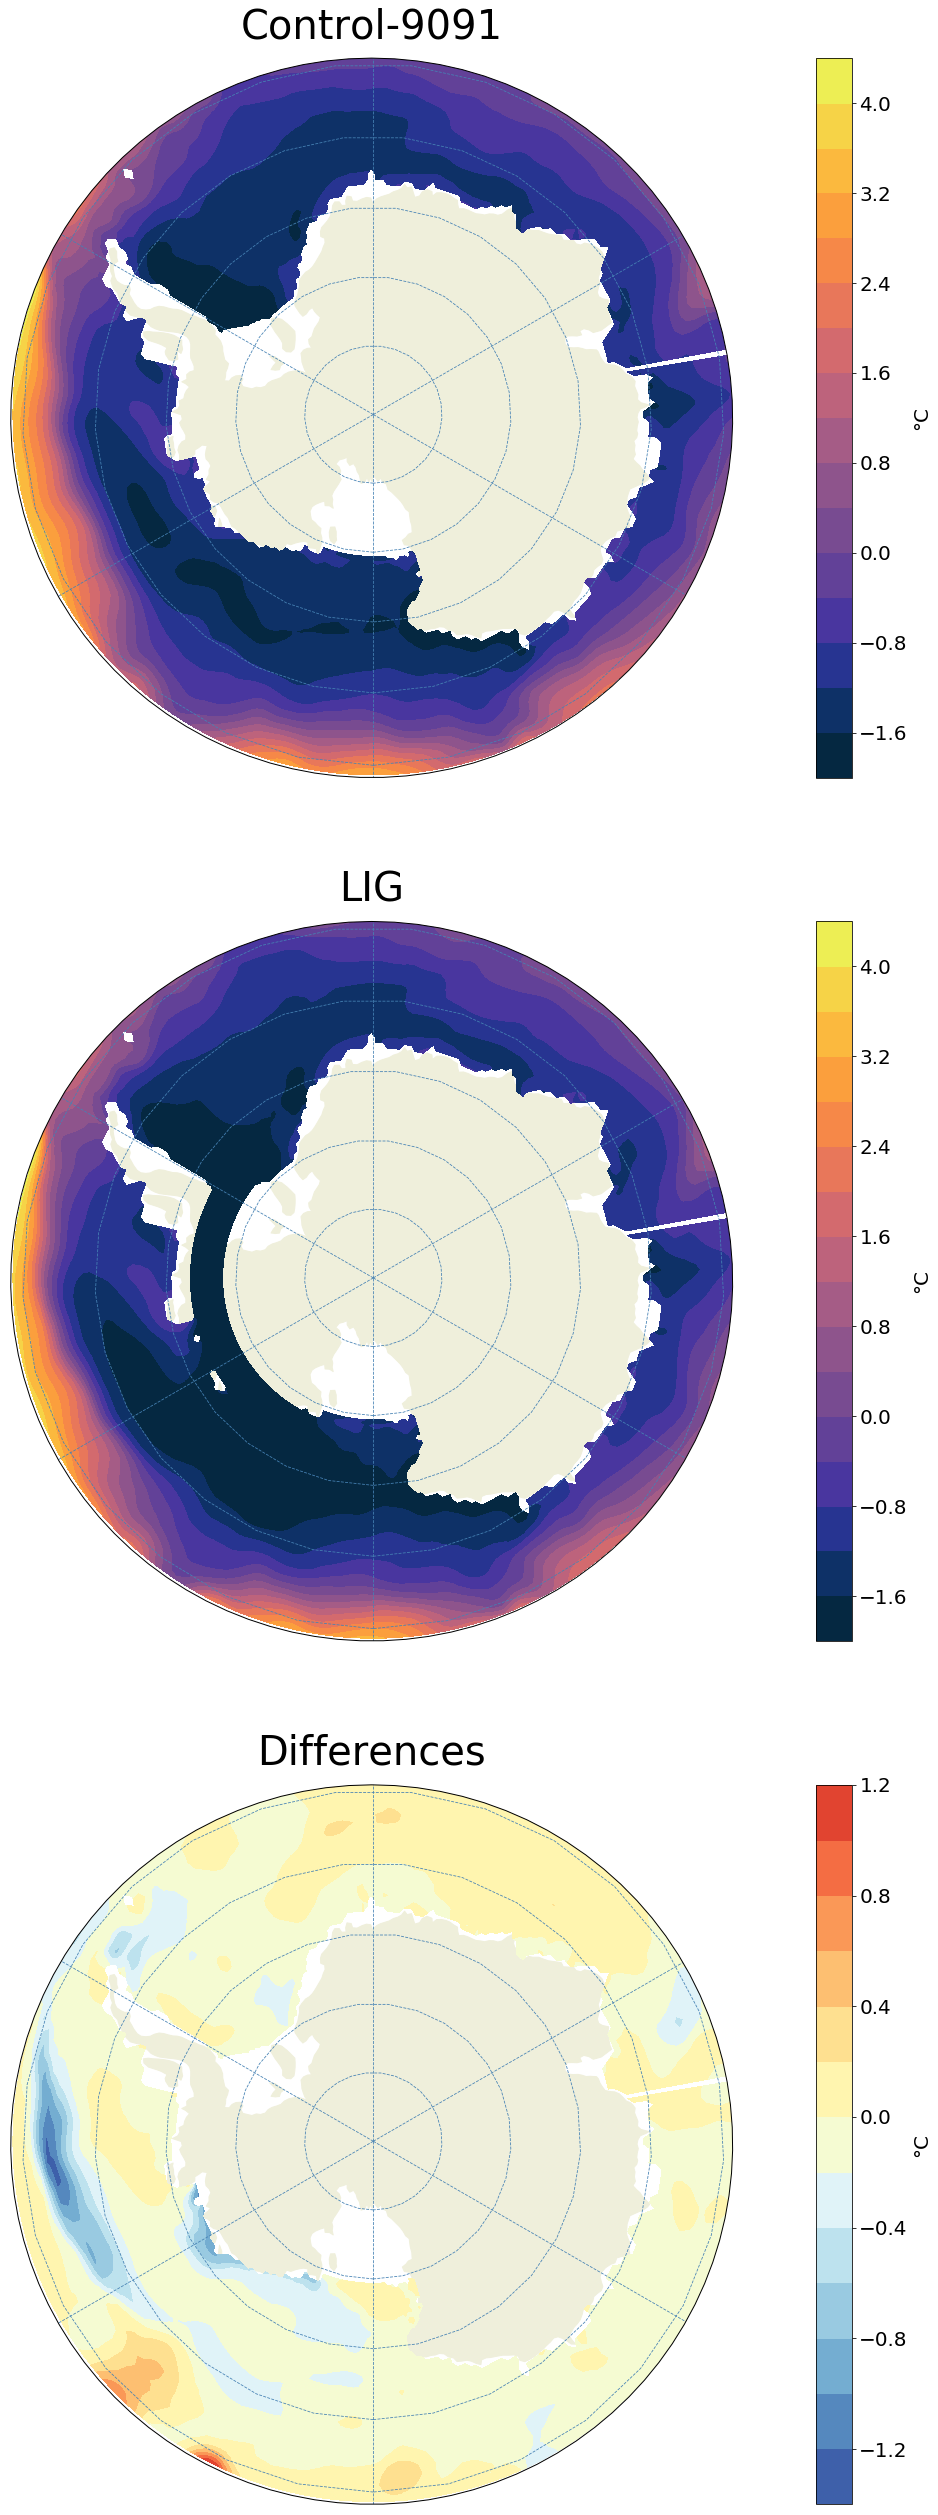

In [60]:
stereo("temp", cmo.thermal, -1.5, "°C", -59, True, True, " - 273.15")

# SALT

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


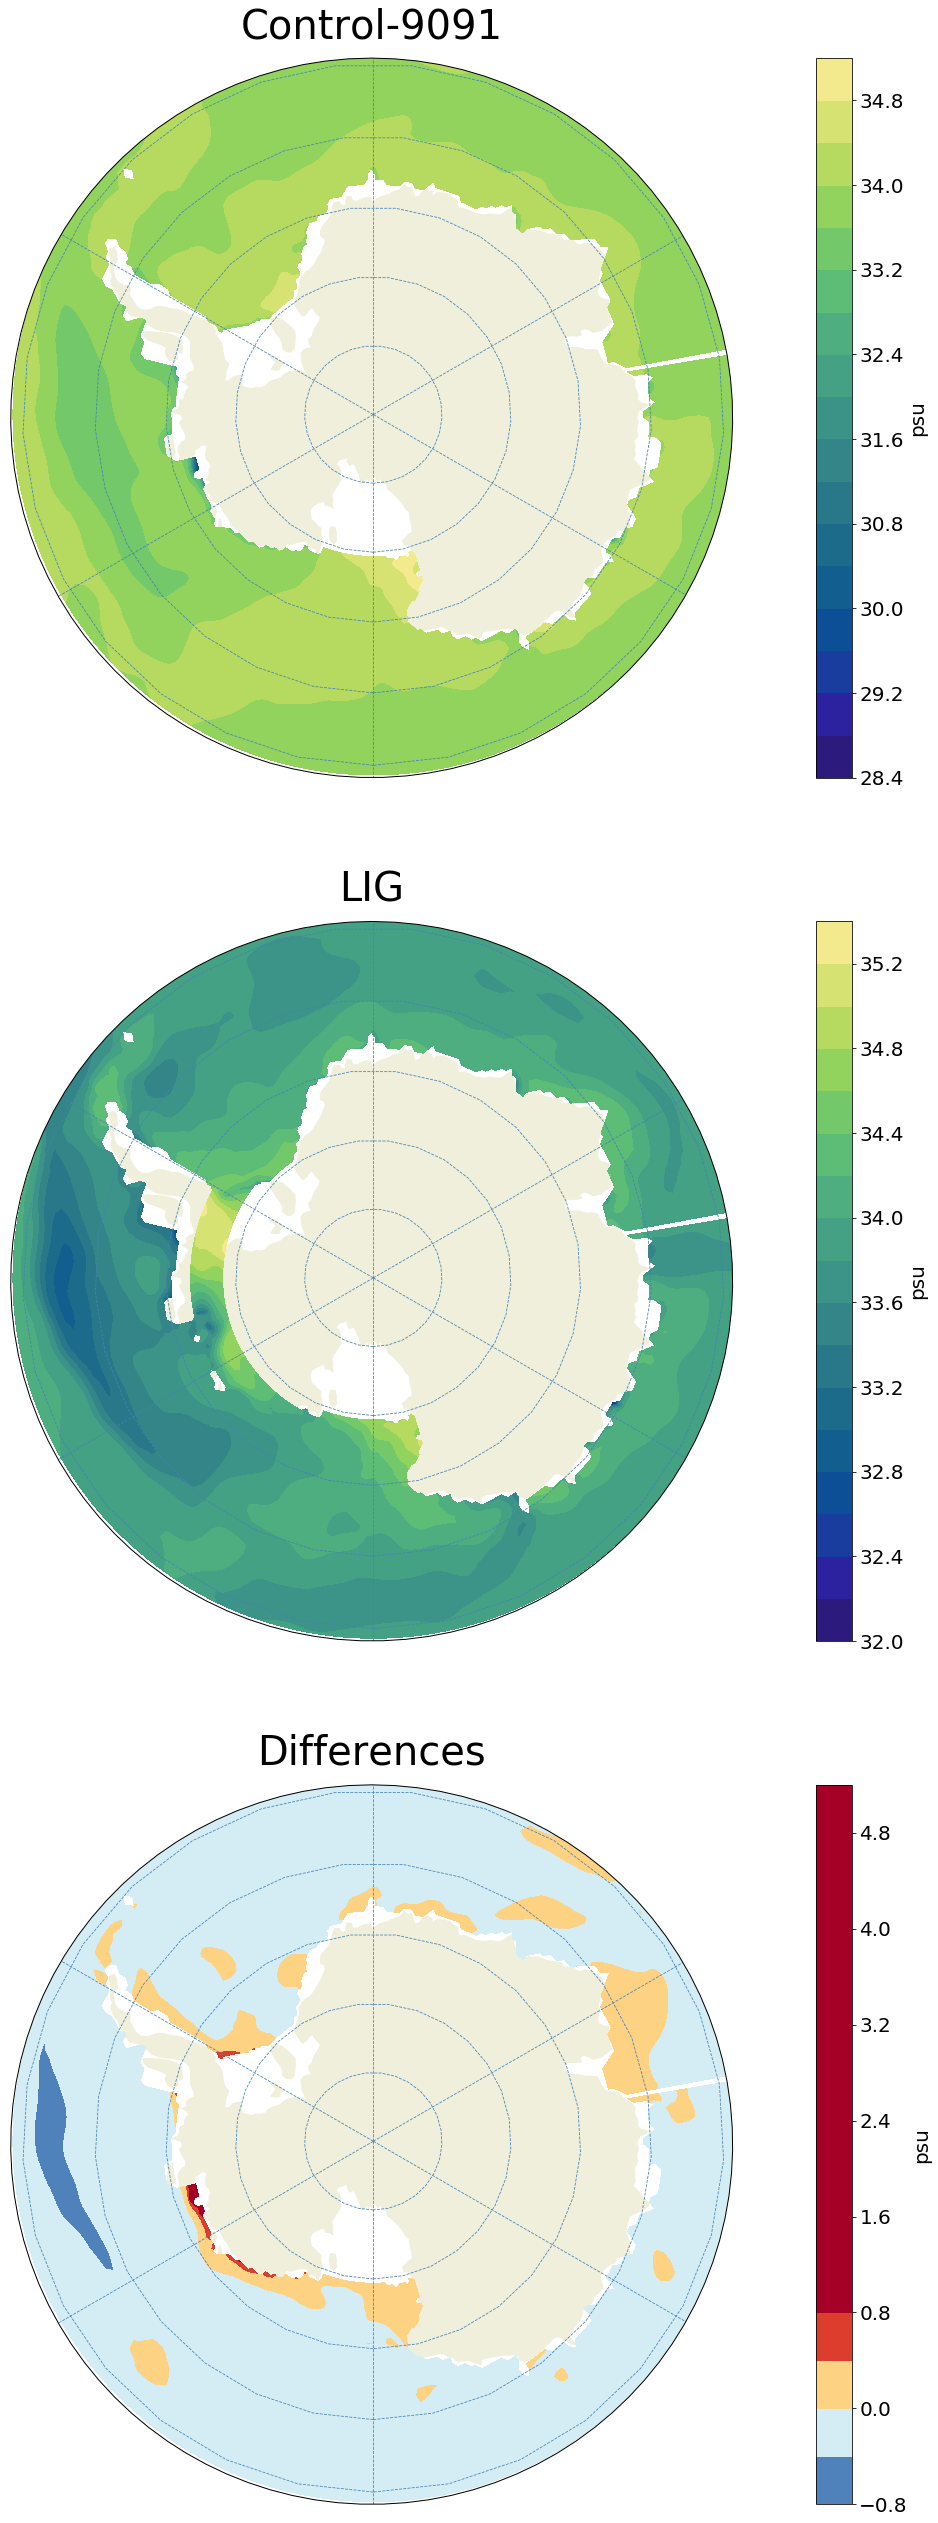

In [89]:
stereo("salt", cmo.haline, -0.8, dso.salt.units, -59, True)

# DENSITY at the SURFACE

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


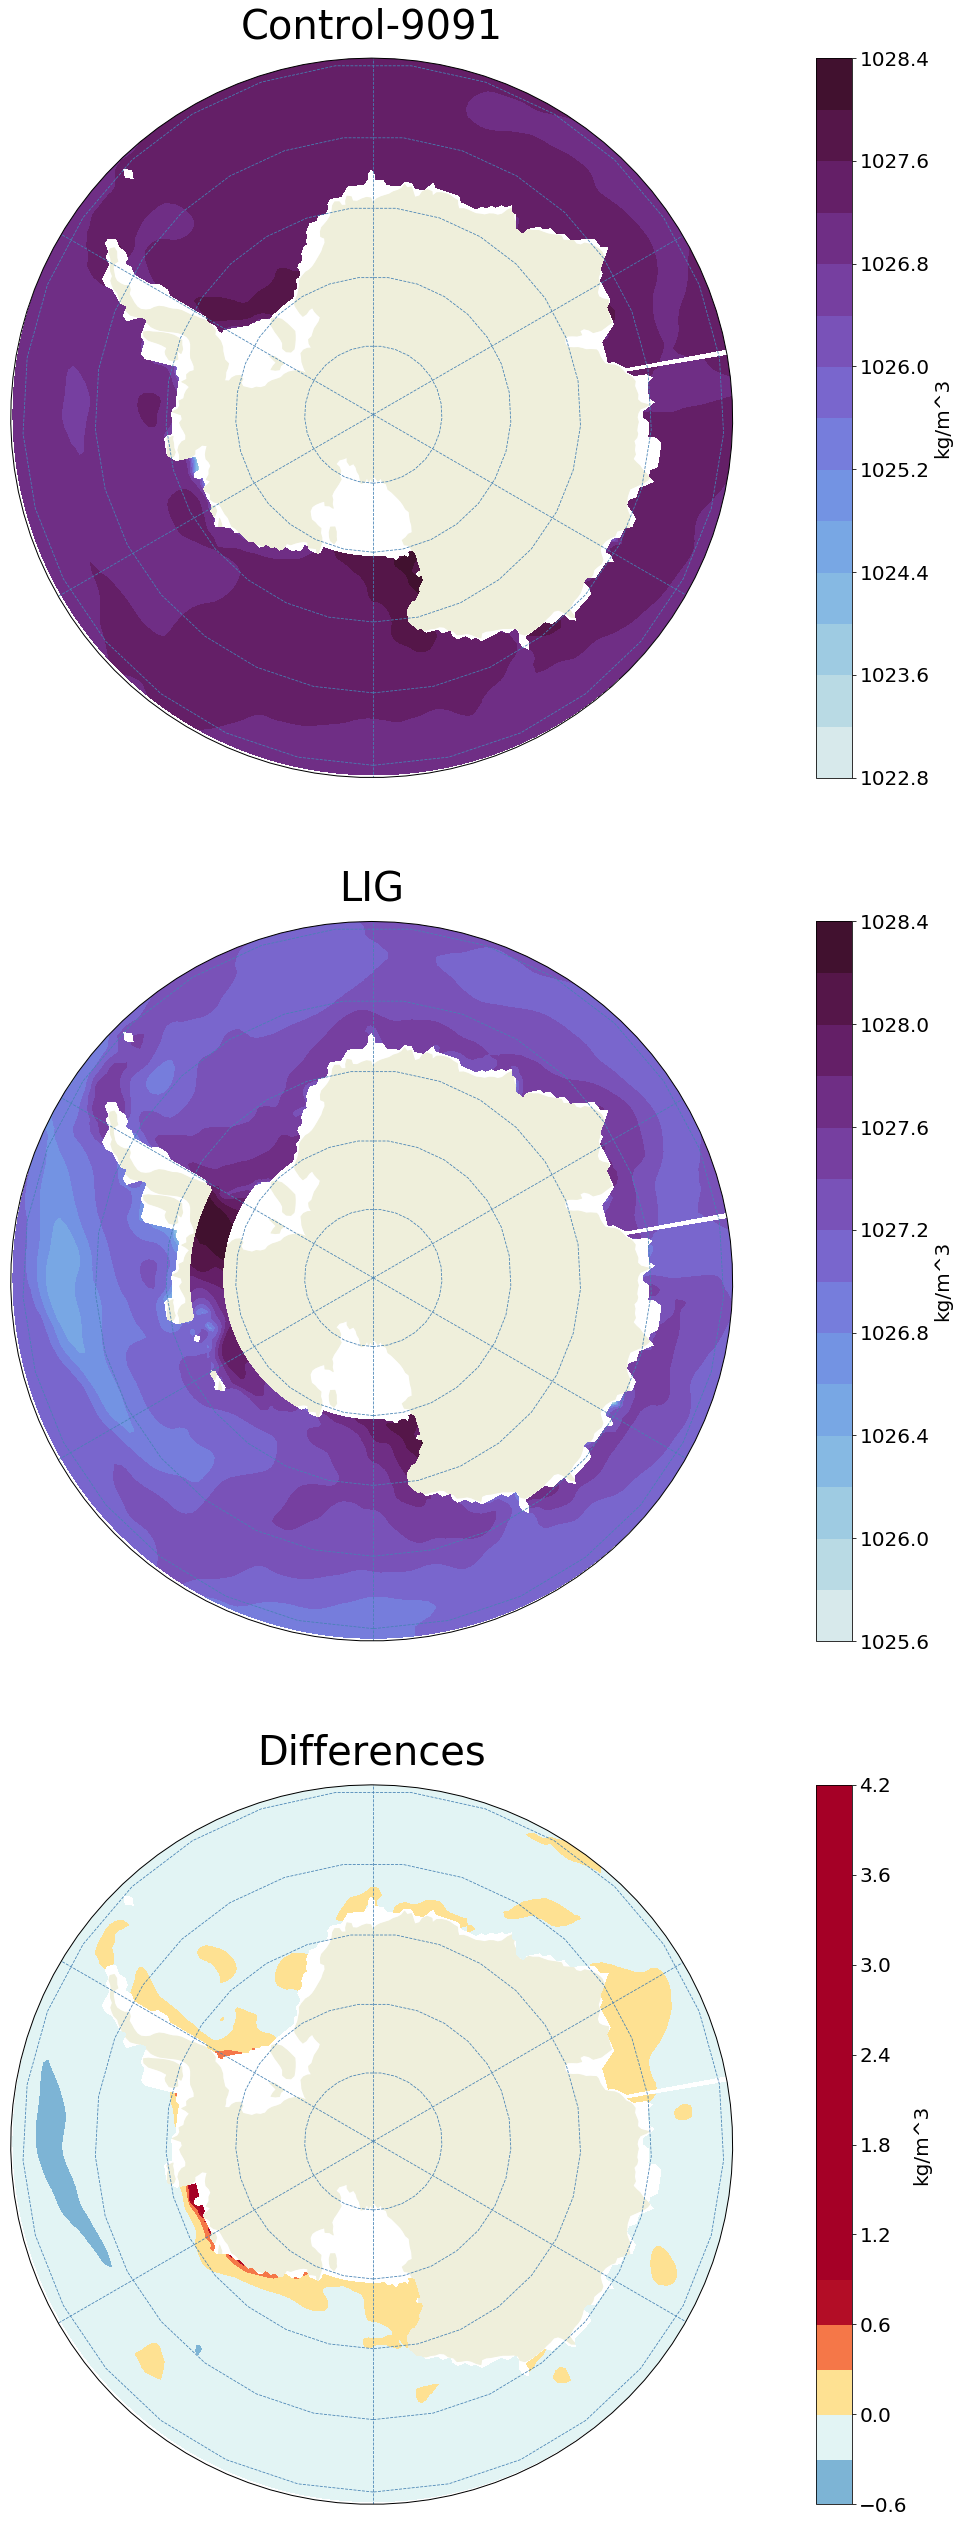

In [90]:
stereo("pot_rho_0", cmo.dense, -0.8, dso.pot_rho_0.units, -59, True)

# DENSITY at 2,000m

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


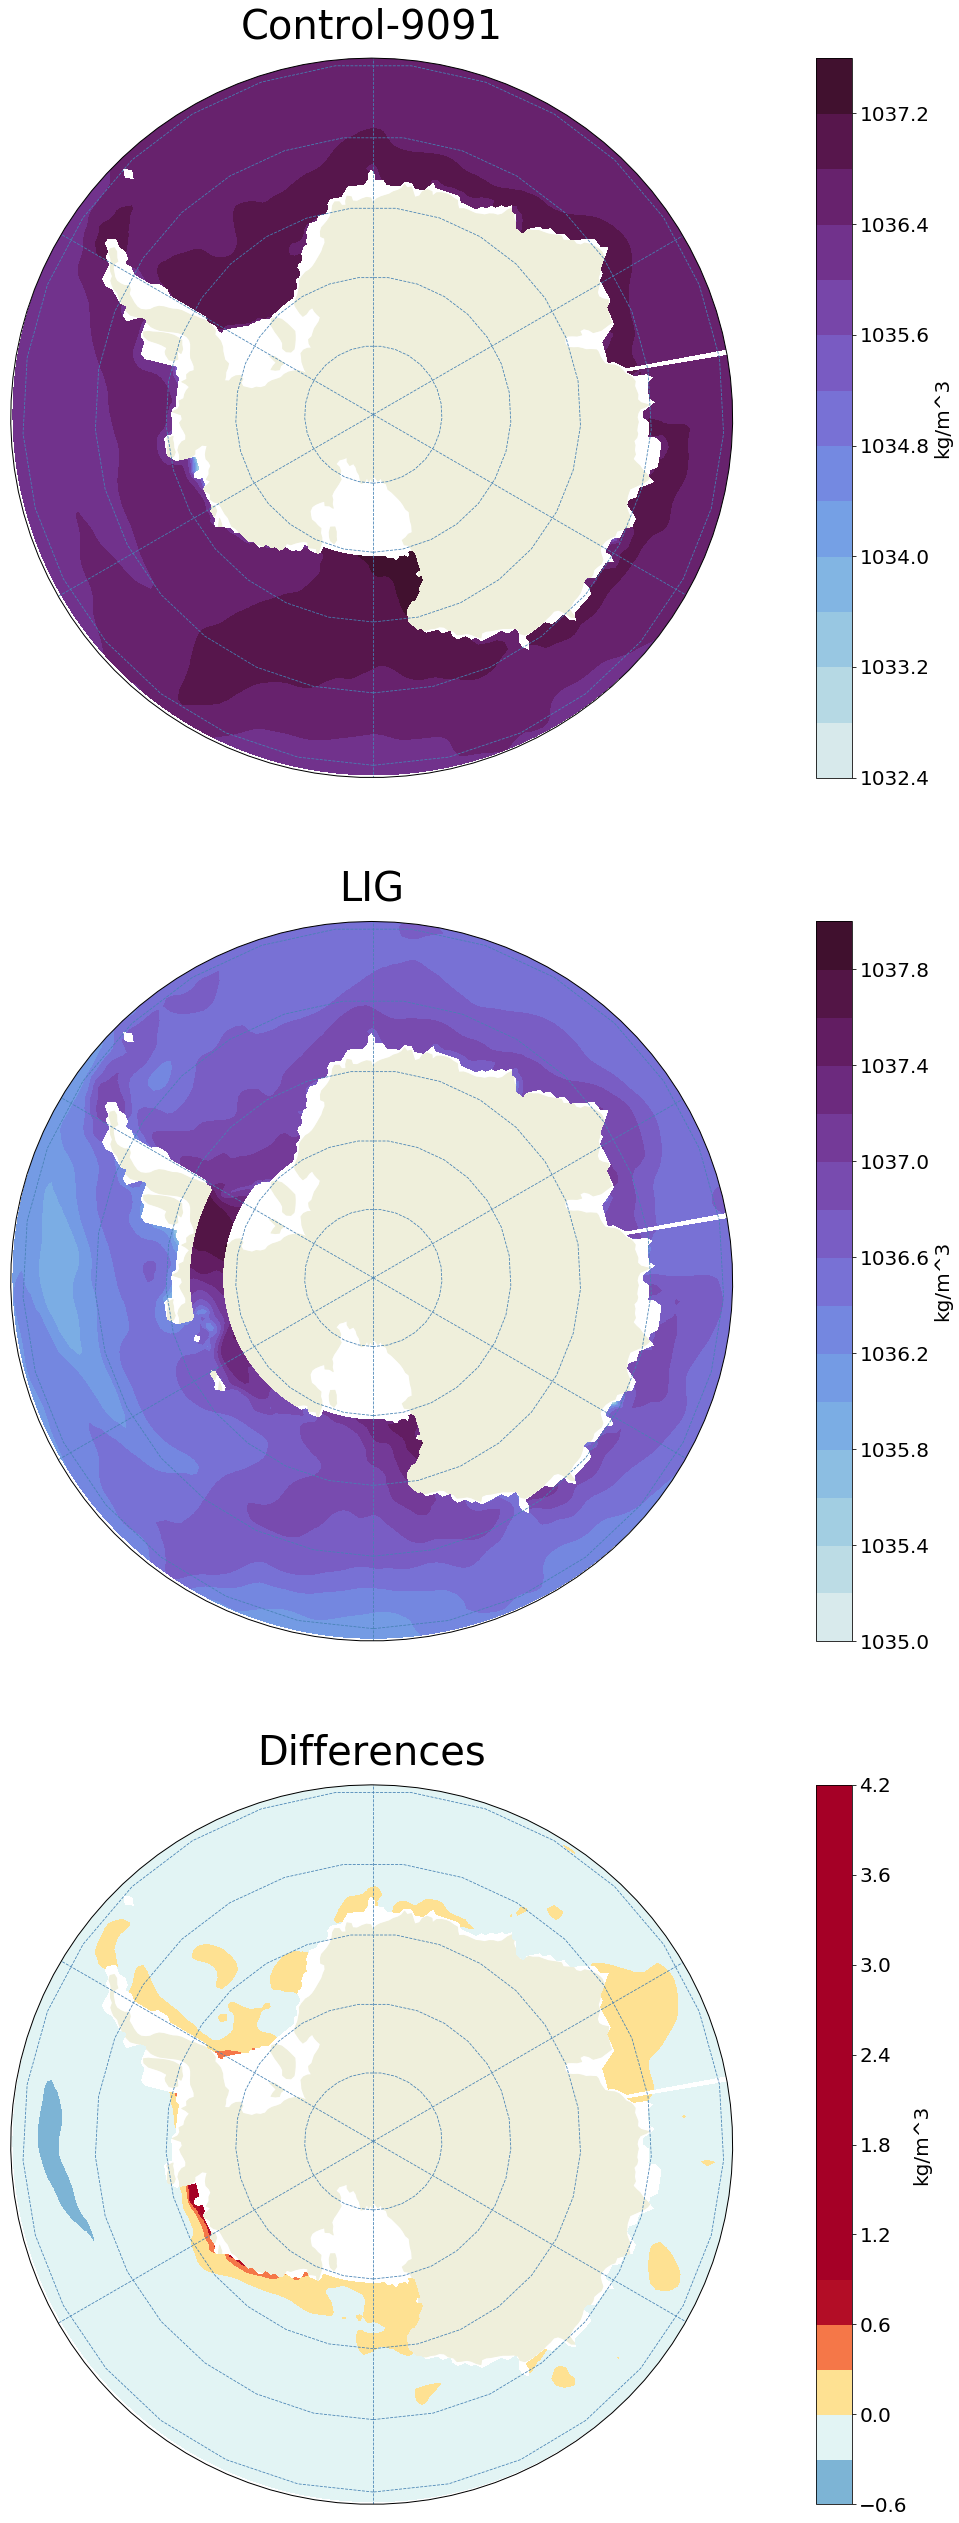

In [91]:
stereo("pot_rho_2", cmo.dense, -0.8, dso.pot_rho_2.units, -59, True)

# Look into /ocean to see what other .nc files exist